In [464]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import gif

import numpy as np
from itertools import product
import pandas as pd
import warnings
import os
from fractions import Fraction
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals

from scipy.optimize import minimize_scalar

# The helper file below brings functions created in previous tutorials
# make_df_for_energy_scan - we made this in tutorial 4
# make_braket_labels - we made this in tutorial 4
# j_states_list
# 
from libs.helper_06_tutorial import *


def simulate(H, psi0, times):
    num_states = H.shape[0]
    
    # create placeholder for values of amplitudes for different states
    psi = np.zeros([num_states,times.size], dtype="complex128")
     # create placeholder for values of occupation probabilities for different states
    P = np.zeros([num_states,times.size], dtype="complex128")
    
    evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)

    for k in range(0,num_states):
        amp = 0
        for i in range(0,num_states):
            amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
        psi[k,:] = amp
        P[k,:] = amp*np.conj(amp)
    return P, psi

## Recap

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$

States described as $|n,\pm \rangle$

For example, if we only allow `max_bosons=4`

In [389]:
max_bosons=4

We can enumerate the states as

In [390]:
# map from QuTiP number states to |n,±, ±> states
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nm_list = [(n,m1) for (n,m1) in product(possible_ns, possible_ms)]

In [391]:
nm_list

[(0, '+'),
 (0, '-'),
 (1, '+'),
 (1, '-'),
 (2, '+'),
 (2, '-'),
 (3, '+'),
 (3, '-'),
 (4, '+'),
 (4, '-')]

and we can represent e.g. $|1, +\rangle$ using the tensor product that we learnt about in [Tutorial 3](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb#3.5---Describing-coupled-systems-in-QuTiP) and 4.

In [392]:
#        bosons,                TSS1, 
tensor(basis(max_bosons+1,1), basis(2,0))

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

We did similar things with the operators that make up the Hamiltonian


- `two_state` = $\frac{1}{2}\sigma_z$
- `bosons` = $a^{\dagger}a +\frac{1}{2}$
- `interaction`= $\left( a^{\dagger} + a \right)\sigma_x$

In [393]:
a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised 𝜎𝑥 operator
sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised 𝜎𝑧 operator

two_state     =  1/2*sz                         # two state system energy operator   𝜎𝑧/2
bosons       =  (a.dag()*a+0.5)                 # boson energy operator              𝑎†𝑎+1/2
number        = a.dag()*a                       # boson number operator              𝑎†𝑎
interaction  = (a.dag() + a) * sx               # interaction energy operator        (𝑎†+𝑎)𝜎𝑥  

We can extend these tensor products to include extra TSS easily. Let's see

## 2 TSS

$$H =  \frac{\Delta E}{2} (\sigma_{z1} + \sigma_{z2}) + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)(\sigma_{x1} + \sigma_{x2})$$

States described as $|n,\pm, \pm \rangle$

Again, if we only allow `max_bosons=4`, then we can enumerate the states in a very similar way to a single TSS


In [394]:
max_bosons=4

In [395]:
# map from QuTiP number states to |n,±, ±> states
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]

In [396]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-'),
 (3, '+', '+'),
 (3, '+', '-'),
 (3, '-', '+'),
 (3, '-', '-'),
 (4, '+', '+'),
 (4, '+', '-'),
 (4, '-', '+'),
 (4, '-', '-')]

the state  $|1,+, + \rangle$ is then represented by:

In [397]:
#           bosons,             TSS1,        TSS2
tensor(basis(max_bosons+1,1), basis(2,0), basis(2,0))

Quantum object: dims = [[5, 2, 2], [1, 1, 1]], shape = (20, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Now for the operators.

- `two_state_1` = $\frac{1}{2}\sigma_{z1}$
- `two_state_2` = $\frac{1}{2}\sigma_{z2}$
- `bosons` = $a^{\dagger}a +\frac{1}{2}$
- `interaction_1`= $\left( a^{\dagger} + a \right)\sigma_{x1}$
- `interaction_2`= $\left( a^{\dagger} + a \right)\sigma_{x2}$

In [447]:
a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator 

two_state_1     =  1/2*sz1                             # two state system energy operator   𝜎𝑧1/2
two_state_2     =  1/2*sz2                             # two state system energy operator   𝜎𝑧2/2
bosons          = (a.dag()*a+0.5)                      # boson energy operator              𝑎†𝑎+1/2
number          = a.dag()*a                            # boson number operator              𝑎†𝑎
interaction_1   = (a.dag() + a) * sx1                  # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
interaction_2   = (a.dag() + a) * sx2                  # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2 

In tutorial 4, we learnt a lot from looking at the Hinton diagram of the Hamiltonian. Let's do the same here.

Let's use example Hamiltonian with $\Delta E = \omega = U = 1$ for this test.

In [448]:
H = 1*two_state_1 + 1*two_state_2 + 1*bosons + 1*interaction_1 + 1*interaction_2

In [449]:
bra_labels, ket_labels = make_braket_labels(nmm_list)

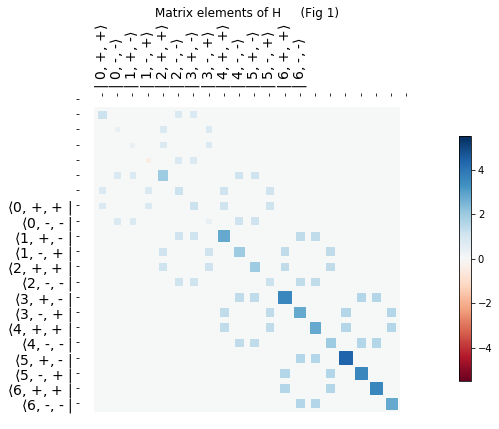

In [450]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 1)");


As we might have imagined the Hinton diagram is more complicated than for a single TSS. Each state is connected to twice as many states as previously. For example, $|0,+, + \rangle$ is directly coupled to the following 2 states:
- $|1,+, - \rangle$
- $|1,-, + \rangle$

Just like the last tutorial, we can start to draw a sequence of horizontal and vertical line to see how the states are connected. There are many more paths now that we have an extra TSS. Let's look at one such path.

>TODO: draw path

$|0,+, + \rangle \rightarrow |1,+, - \rangle \rightarrow |2,-, - \rangle \rightarrow |3,+, - \rangle \rightarrow |4,-, - \rangle$

We can expect that the indirect path from $|0,+, + \rangle \rightarrow |2,-, - \rangle$ could be realised by setting $\Delta E = \omega$ so that a boson would be emitted by each TSS as they transition from + to -. We've seen similar physics from a single TSS - nothing controversial here.

We can also expect (similarly to the previous tutorial) that the indirect path from $|0,+, + \rangle \rightarrow |4,-, - \rangle$ could be realised by setting $\Delta E = 2\omega$ so that 2 bosons would be emitted by each TSS as they transition from + to -.  This is another example of down conversion that we found last time.

We can make also paths like below

>TODO: draw paths

$|1,+, - \rangle \rightarrow |0,+, + \rangle \rightarrow |1,-, + \rangle$

This is something different to what we encountered before - how would we describe such paths? We could call the indirect path from $|1,+, - \rangle \rightarrow |1,-, + \rangle$   excitation transfer because the "excitation" (i.e. the +) moves from one TSS to the other.


---
In tutorial 4 we discovered that two distinct parity universes existed which can be treated in isolation

We could distinguish the parity using the operator $\sigma_z e^{i\pi n}$ where $n$ is the boson number operator.

A simple extension of this idea for 2 TSS is simply  $\sigma_{z1}\sigma_{z2} e^{i\pi n}$. Let's see what it looks like

In [408]:
P = sz1*sz2*(1j*np.pi*number).expm()              # parity operator

In [409]:
bra_labels, ket_labels = make_braket_labels(nmm_list)

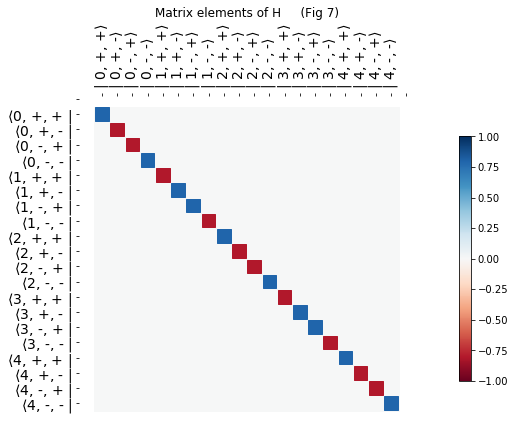

In [410]:
f, ax = hinton(P, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 7)");

It takes on a binary $\pm 1$ as we saw in the last tutorial. The most important question is, does it commute with the Hamiltonian - if it does that we have a well defined parity operator that we can use to split the universes.

Let's use example Hamiltonian with $\Delta E = \omega = U = 1$ for this test.

In [411]:
H = 1*two_state_1 + 1*two_state_2 + 1*bosons + 1*interaction_1 + 1*interaction_2

In [412]:
commutator(H,P).full

<bound method Qobj.full of Quantum object: dims = [[5, 2, 2], [5, 2, 2]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Great! We are now ready to put this all together in much the same way we did in the last tutorial, i.e. we create a function.

In [413]:
def make_operators(max_bosons, parity=0):
    
    a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
    sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
    sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator 

    two_state_1     =  1/2*sz1                                  # two state system energy operator   𝜎𝑧1/2
    two_state_2     =  1/2*sz2                                  # two state system energy operator   𝜎𝑧2/2
    bosons          = (a.dag()*a+0.5)                           # boson energy operator              𝑎†𝑎+1/2
    number          = a.dag()*a                                 # boson number operator              𝑎†𝑎
    interaction_1   = (a.dag() + a) * sx1                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a.dag() + a) * sx2                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2  
    
    P = sz1*sz2*(1j*np.pi*number).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        nmm_list        = [nmm_list[i] for i in p]
    
    
    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list

### Energy level landscape $U=0$

In [414]:
# ODD PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(
    max_bosons=6, parity=-1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons 
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [415]:
# EVEN PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(
    max_bosons=6, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons 
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

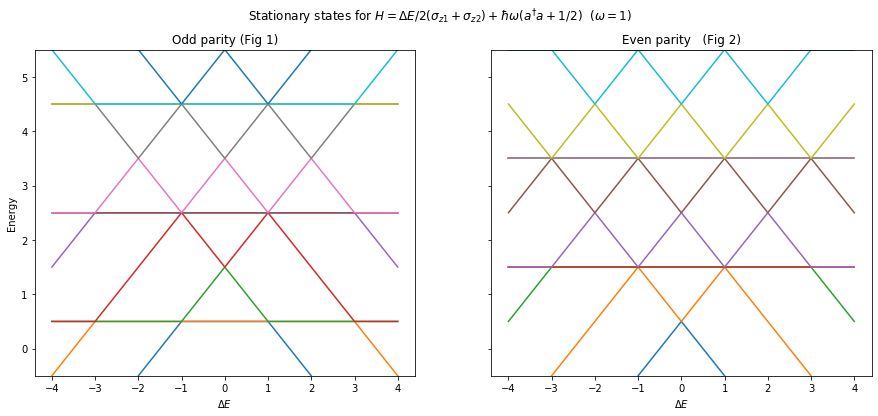

In [416]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)

fig.suptitle("Stationary states for $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) $  ($\omega=1$)")


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd parity (Fig 1)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even parity   (Fig 2)",  ax=axes[1]);

axes[0].set_ylabel("Energy");



What can we say about fig xxx?

Compared to Fig 1 of tutorial 3, we have some similarities and some differences:
- Similarity - levels that trend up and down with $\Delta E$. These correspond to states like $|n,+,+\rangle$ and $|n,-,-\rangle$
- Difference - horizontal levels. These correspond to combinations of $|n,+,-\rangle$ and $|n,-,+\rangle$ which give is no overall "excitation" i.e. equal amounts of + and -. This kind of combination of basis states is often referred to as an [entangled state](https://en.wikipedia.org/wiki/Quantum_entanglement#Pure_states). 
 >The subject of quantum entanglement deserves at least a whole tutorial, so we'll come back to it another time.


Thinking now more carefully about the horizontal levels, there are 2 ways we can combine these states together for a given $n$:
- $|n,+,-\rangle + |n,-,+\rangle$ 
- $|n,+,-\rangle  - |n,-,+\rangle$ 

These states are reminiscent of the "in phase" and "out of phase" states that we described back in tutorial 1.  The two combinations give us an expectation that each horizontal line is in fact 2 horizontal lines on top of each other.

What else can we say?

When looking at where the levels appear to cross, we now suspect that there are two different situations:
- 2 levels come together - we've seen this before and we expect these to form anti-crossings when we switch the coupling on
- 4 levels come together - we've not encountered this before so we need to explore it.

Let's focus on even parity for now, i.e Fig 2, and switch on the coupling.

## Crossings and anti-crossings

In [721]:
# EVEN PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(
    max_bosons=6, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

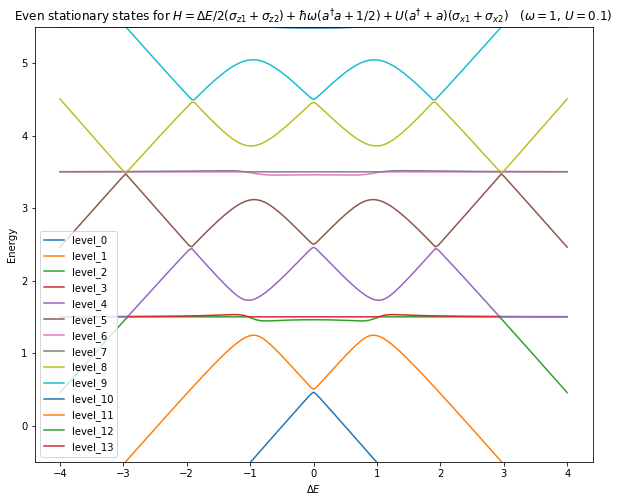

In [722]:
df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=True, 
        title="Even stationary states for $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$   ($\omega=1$, $U=0.1$)",
             figsize=(10,8));

plt.ylabel("Energy");


There are many things we can see from fig XXX:
1. Where 2 levels have come together we see an anti-crossing as we have come to expect from interacting levels, e.g. levels 4 and 5.
2. The horizontal levels of Fig XXX have split into 2 levels as we suspected. This reveals that 4 levels are indeed coming together at some anti-crossings, e.g. levels 1,2,3,4
3. One of the previously horizontal levels appears to remain horizontal, i.e. it is unaffected by the coupling
4. There appear to still be genuine crossings between some levels, most strikingly seen at the intersection of levels 2 and 3 - this indicates there might be non interacting sub-universes with each parity universe 🤯

There is a lot to explore and understand, let's start with point 1, i.e. two levels anti-crossing - this is the most familiar to us, then move onto looking at 3 and 4 in States with no overall excitation before returning to 2.

### Two Level anti-crossing

Levels 4 an 5 anti-cross at around $\Delta E = 2\omega$. This anti-crossing looks like it could be linked to the $|0,+, + \rangle \rightarrow |4,-, - \rangle$ down conversion that we talked about when we explored the Hinton diagram.

Let's see if we can simulation such down conversion just as we did in Fig 12 of tutorial 4. Rather than manually zoom in on the anti-crossing to get a more precise value of $\Delta E$ to use in the simulation, we will automate the process using [`minimize_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) from [`scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html)

How will we use `minimize_scalar`? We first need to provide a function that calculates the difference in the energies of two levels.

In [755]:
def level_difference(DeltaE, omega, U, level_number):
    H = DeltaE*two_state_1 + DeltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
    evals, ekets = H.eigenstates()
    return np.abs(evals[level_number] - evals[level_number-1])


We can now pass this `level_difference` to `minimise_scalar` where the first argument will be used by `minimize_scalar` as a variable and the rest will be considered as "arguments" (i.e. fixed constants). Finally, we must specify $\Delta E$ `bounds` in which we expect to find the anti-crossing.

Let's give it a go using:
- `omega = 1`
- `U = 0.1`
- `level_number = 5`
- `bounds = [1.9, 2]`

In [771]:
# oemga = 1
# U = 0.1
# level_number 5 - this will allow us to calculate level_5/4 energy difference
anti_crossing = minimize_scalar(level_difference, args=(1, 0.1, 5), method="Bounded", bounds=[1.9, 2])

In [772]:
anti_crossing

     fun: 9.46982193181789e-05
 message: 'Solution found.'
    nfev: 16
  status: 0
 success: True
       x: 1.9328593467366724

We see that the true anti-crossing occurs at $\Delta E = 1.9328593467366724$. Let's now use this value to create the Hamiltonian for our simulation.

In [760]:
H = anti_crossing.x*two_state_1 + anti_crossing.x*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2

We want to start the system off in the $|0,+, + \rangle$ state - this should be the first state in the state list, let's check

In [761]:
nmm_list[0]

(0, '+', '+')

Great. We can now set up the initial state by using the `basis` function as we have done before.

In [762]:
psi0 = basis(len(nmm_list), 0)

Now we are ready to simulate

In [763]:
times = np.linspace(0.0, 100000.0, 10000)
P, psi = simulate(H, psi0, times)

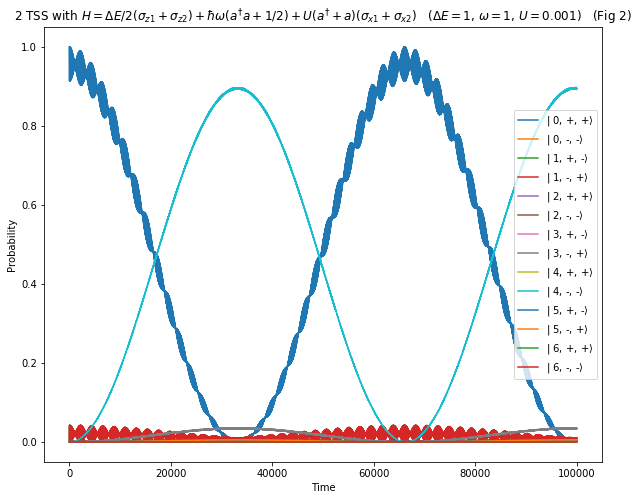

In [764]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("2 TSS with $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$   ($\Delta E = 1$, $\omega=1$, $U=0.001$)   (Fig 2)")
plt.show();



We can see the down conversion that we expected to see, i.e. both TSS transition from + to - giving of 2 bosons in the process, i.e. $|0,+, + \rangle \rightarrow |4,-, - \rangle$.

### States with no overall excitation

From fig xx, we found something unexpected for the energy levels corresponding to no overall excitation, i.e. those consisting of equal number of + and -. 
- It seemed like one of the levels remains horizontal even though we turned the coupling on.
- It seems like the energy levels with no overall excitation can actually cross 

What are these observations telling us?

We'll first set $\Delta E = 0$ and inspect levels 2 and 3

In [851]:
DeltaE = 0

In [852]:
H = DeltaE*two_state_1 + DeltaE*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2

In [853]:
evals, ekets = H.eigenstates()

Let's look at the energy of levels 2 and 3

In [854]:
evals[2:4]

array([1.46, 1.5 ])

level 3 is exactly 1.5 as it was when we didn't have any coupling between the TSS and the boson field.

In [855]:
prettify_states(ekets, nmm_list)[[2,3]]

,2,3
"(0, +, +)",-0.1+0.0j,0.0+0.0j
"(0, -, -)",-0.1+0.0j,0.0+0.0j
"(1, +, -)",-0.7+0.0j,0.7+0.0j
"(1, -, +)",-0.7+0.0j,-0.7+0.0j
"(2, +, +)",0.2+0.0j,0.0+0.0j
"(2, -, -)",0.2+0.0j,0.0+0.0j
"(3, +, -)",-0.0+0.0j,0.0+0.0j
"(3, -, +)",-0.0+0.0j,0.0+0.0j
"(4, +, +)",0.0+0.0j,0.0+0.0j
"(4, -, -)",0.0+0.0j,0.0+0.0j


We can see that levels 2 and 3 are normlaised versions of: 
- level 2 = $|1,+,-\rangle  + |1,-,+\rangle$ +  other states with boson number different from 1
- level 3 = $|1,+,-\rangle  - |1,-,+\rangle$ 

This pattern persists as we change $\Delta E$, i.e. the energy of level 3 continues to be 1.5 and the eigenstate continues to be the normalised "out of phase" state  $|1,+,-\rangle  - |1,-,+\rangle$ - try it out for yourself by changing the $\Delta E$ in the above Hamiltonian.

So, it seems to be true that the state $|1,+,-\rangle  - |1,-,+\rangle$ (and others like it with different boson number) live in their own independent sub-universe and don't interact with the other states. What is the physics behind this? Why is it that changing plus to minus in $|1,+,-\rangle  \pm |1,-,+\rangle$ makes such a difference? It's an important question but one that takes us somewhat away from the primary mission of this tutorial. We'll come back to this in the next tutorial.

> For those who just can't wait that long, it has to do with angular momentum and spin


In [856]:
H = 0*two_state_1 + 0*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2

In [869]:
psi0 = (basis(len(nmm_list), 2) - basis(len(nmm_list), 3)).unit()

In [870]:
times = np.linspace(0.0, 100.0, 10000)
P, psi = simulate(H, psi0, times)

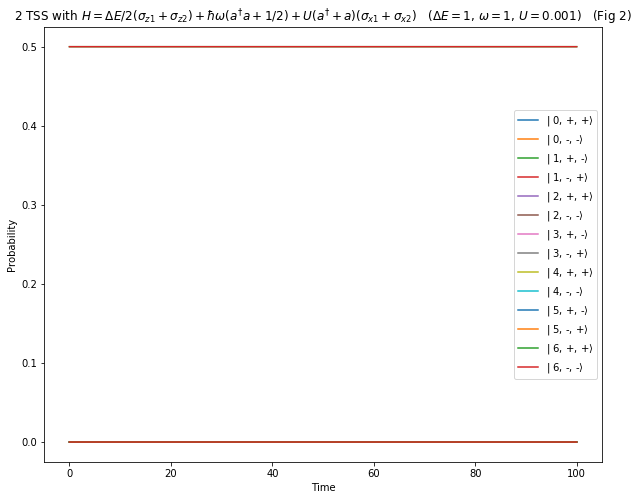

In [871]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("2 TSS with $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$   ($\Delta E = 1$, $\omega=1$, $U=0.001$)   (Fig 2)")
plt.show();




This suggests that when we have an anti-crossing with 4 levels, it's only 3 of the 4 that are coupled to each other and hence cause the splitting in energy which we have seen so many times now.

In [ ]:
anti_crossing = minimize_scalar(level_difference, args=(1, 0.1, 5), method="Bounded", tol=1e-10, bounds=[1.9, 2])

In [800]:
crossing = minimize_scalar(level_difference, args=(1, 0.1, 3), method="Bounded", bounds=[0.8, 1.2], tol=1e-15)

In [801]:
crossing

     fun: 1.011385419857902e-09
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 1.0304893278037937

In [817]:
H = 1.03*two_state_1 + 1.03*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2

In [818]:
evals, ekets = H.eigenstates()

In [820]:
ekets[3]

Quantum object: dims = [[14], [1]], shape = (14, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.        ]
 [-0.70710678]
 [ 0.70710678]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]

In [431]:
times = np.linspace(0.0, 100.0, 10000)
P, psi = simulate(H, psi0, times)

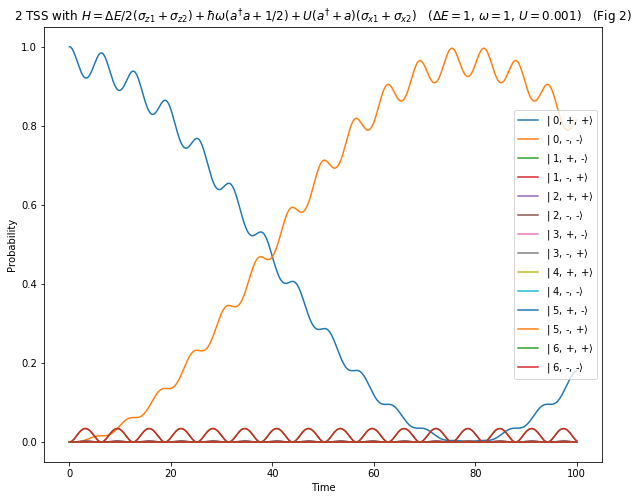

In [432]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("2 TSS with $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$   ($\Delta E = 1$, $\omega=1$, $U=0.001$)   (Fig 2)")
plt.show();




## Down conversion 3 bosons

In [171]:
# EVEN PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(
    max_bosons=6, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", 2.965, 2.9654, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

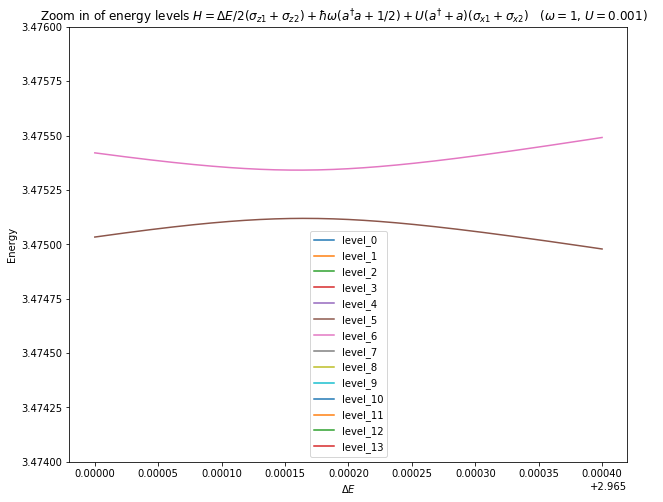

In [175]:
df_even.plot(x="$\Delta E$",figsize=(10,8),ylim=[3.474,3.476],legend=True, 
        title="Zoom in of energy levels $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$   ($\omega=1$, $U=0.001$)   ");
plt.ylabel("Energy");



In [179]:
H = 2.96518*two_state_1 + 2.96518*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2

In [180]:
times = np.linspace(0.0, 50000.0, 1000)
P, psi = simulate(H, psi0, times)

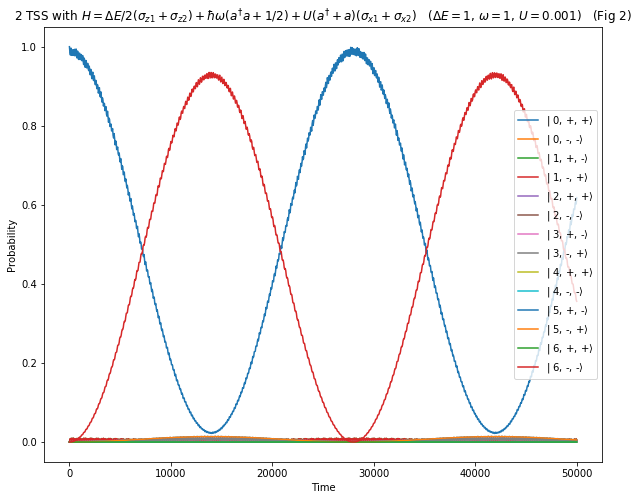

In [181]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("2 TSS with $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$   ($\Delta E = 1$, $\omega=1$, $U=0.001$)   (Fig 2)")
plt.show();




In [87]:
# EVEN PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(
    max_bosons=4, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", 0.7, 1.3, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

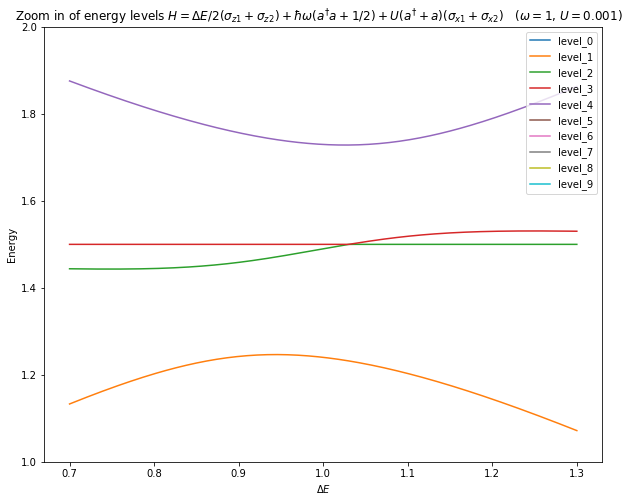

In [88]:
df_even.plot(x="$\Delta E$",figsize=(10,8),ylim=[1,2],legend=True, 
        title="Zoom in of energy levels $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$   ($\omega=1$, $U=0.001$)   ");
plt.ylabel("Energy");



In [40]:
# EVEN PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators(
    max_bosons=3, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", 0.995, 1.005, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

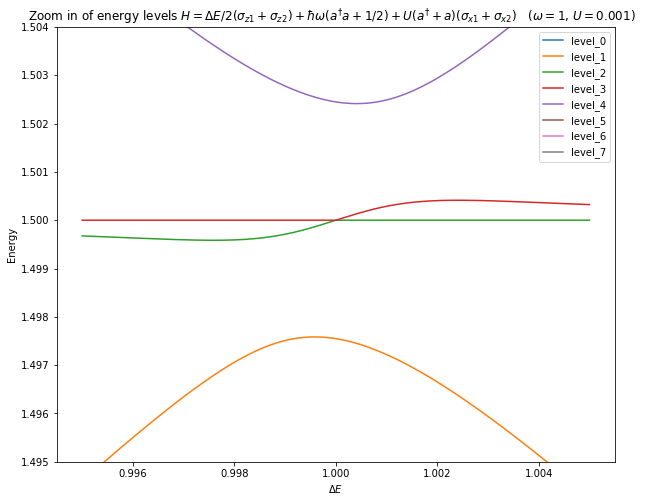

In [41]:
df_even.plot(x="$\Delta E$",figsize=(10,8),ylim=[1.495,1.504],legend=True, 
        title="Zoom in of energy levels $H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$   ($\omega=1$, $U=0.001$)   ");
plt.ylabel("Energy");



---

## Dicke basis

In [55]:
def make_operators(num_tss, j, max_bosons, parity=0):
    
    j_index, jm_list = j_states_list(num_tss)
        
    try:
        j_index[j]
    except:
        raise Exception(f"j needs to be one of {j_vals(num_tss)}")

    
    num_ms = len(m_vals(j)) # number of states in this j universe
    
     # Create the J operator for the number of TSS we have specified
    J = jspin(num_tss)
    
    
    # Now we extract only the states (and labels for those states) for the j we have specified 
    J = [Ji.extract_states(j_index[j]) for Ji in J]  # Loops through the 3 J components and does `extract` for each one
    jm_list = [jm_list[i] for i in j_index[j]]  
    
    # map from QuTiP number states to |n, j, m> states
    possible_ns = range(0, max_bosons+1)
    njm_list = [(n,j,m) for (n,(j,m)) in product(possible_ns, jm_list)]

    
    a        = tensor(destroy(max_bosons+1), qeye(num_ms))     # tensorised boson destruction operator
    number   = tensor(num(max_bosons+1), qeye(num_ms))         # tensorised boson number operator
    Jz       = tensor(qeye(max_bosons+1), J[2])                  # tensorised sigma_x operator 1
    Jx       = tensor(qeye(max_bosons+1), J[0])                  # tensorised sigma_x operator 1
    Jy       = tensor(qeye(max_bosons+1), J[1])                  # tensorised sigma_x operator 1
    J2 = Jx*Jx + Jy*Jy + Jz*Jz
    
    bosons         =   (number+0.5)                                # boson energy operator
    interaction  =    (a.dag() + a) *2*Jx                        # interaction energy operator
    
    if(num_ms==1):
        interaction.dims = [[max_bosons+1,1],[max_bosons+1,1]]
        
    # PARITY STUFF
    
    M = tensor(qeye(max_bosons+1),qdiags(m_vals(j)[::-1],0))             # M operator
    
    if((2*j)%2==0):
        P = (1j*np.pi*M).expm()*(1j*np.pi*number).expm()                  # parity operator 
    else:
        P = 1j*(1j*np.pi*M).expm()*(1j*np.pi*number).expm() 
    
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        Jz     = Jz.extract_states(p)
        Jx     = Jx.extract_states(p)
        Jy     = Jy.extract_states(p)
        J2     = J2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction   = interaction.extract_states(p)
        P               = P.extract_states(p)
        njm_list         = [njm_list[i] for i in p]
        
    
        
    return [Jx,Jy,Jz], bosons, interaction, number, njm_list, P, J2

In [56]:
# ODD PARITY

J, bosons, interaction, number, njm_list, P, J2 = make_operators(num_tss=2, j=1, max_bosons=3, parity=-1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4,4, 201, J[2].shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*J[2] + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 
    

In [57]:
# EVEN PARITY

J, bosons, interaction, number, njm_list, P, J2 = make_operators(num_tss=2, j=1, max_bosons=3, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4,4, 201, J[2].shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*J[2] + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

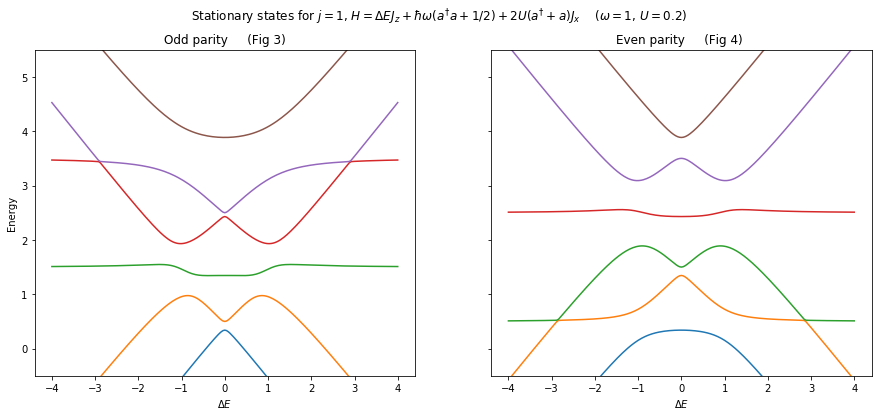

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)

fig.suptitle("Stationary states for $j=1$, $H=\Delta E J_{z} +\hbar\omega(a^{{\dagger}}a +1/2)  +  2U( a^{{\dagger}} + a )J_{x}$    ($\omega=1$, $U=0.2$)")


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd parity     (Fig 3)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even parity     (Fig 4) ",  ax=axes[1]);

axes[0].set_ylabel("Energy");